In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Epoch 1/20 - Loss: 0.4109 - Accuracy: 0.6439
Epoch 2/20 - Loss: 0.3994 - Accuracy: 0.6591
Epoch 3/20 - Loss: 0.3916 - Accuracy: 0.6682
Epoch 4/20 - Loss: 0.3854 - Accuracy: 0.6788
Epoch 5/20 - Loss: 0.3799 - Accuracy: 0.6833
Epoch 6/20 - Loss: 0.3749 - Accuracy: 0.6955
Epoch 7/20 - Loss: 0.3703 - Accuracy: 0.6985
Epoch 8/20 - Loss: 0.3659 - Accuracy: 0.7091
Epoch 9/20 - Loss: 0.3618 - Accuracy: 0.7182
Epoch 10/20 - Loss: 0.3579 - Accuracy: 0.7197
Epoch 11/20 - Loss: 0.3541 - Accuracy: 0.7318
Epoch 12/20 - Loss: 0.3506 - Accuracy: 0.7333
Epoch 13/20 - Loss: 0.3472 - Accuracy: 0.7364
Epoch 14/20 - Loss: 0.3440 - Accuracy: 0.7379
Epoch 15/20 - Loss: 0.3408 - Accuracy: 0.7364
Epoch 16/20 - Loss: 0.3378 - Accuracy: 0.7394
Epoch 17/20 - Loss: 0.3349 - Accuracy: 0.7485
Epoch 18/20 - Loss: 0.3321 - Accuracy: 0.7455
Epoch 19/20 - Loss: 0.3294 - Accuracy: 0.7439
Epoch 20/20 - Loss: 0.3268 - Accuracy: 0.7470
Model Accuracy:  0.746969696969697
Loss:  0.35978264553750644


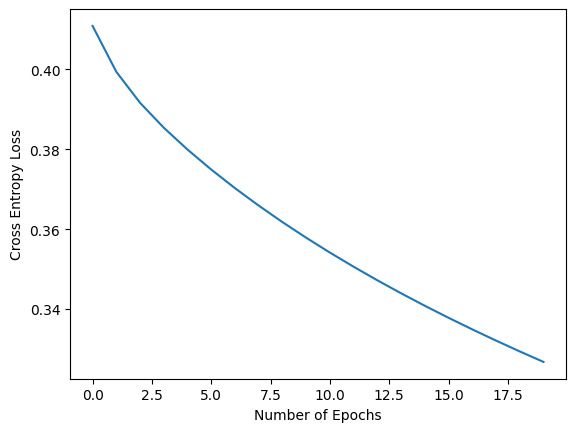

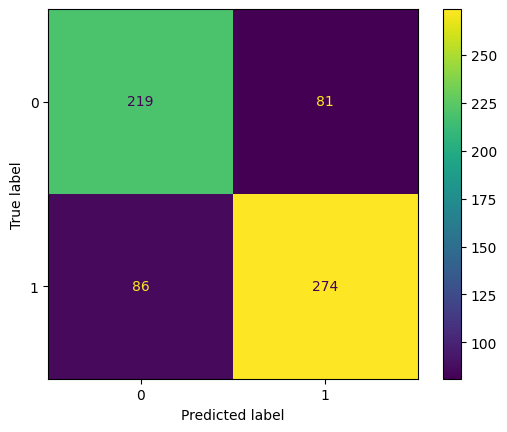

In [7]:

import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import skimage as ski
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

class LogisticRegression():

    def __init__(self, lr=0.001, epochs=20, regularization=None, lambda_=0.01):
        self.lr = lr
        self.epochs = epochs
        self.weights = None
        self.bias = None
        self.loss_list = None
        self.regularization = regularization
        self.lambda_ = lambda_

    def fit(self, training_samples, training_labels, validation_samples, validation_labels):
        num_samples, num_features = training_samples.shape
        self.weights = np.zeros(num_features)
        self.bias = 0
        self.loss_list = []
        class_weights = compute_class_weight('balanced', classes=np.unique(training_labels), y=training_labels)
        class_weight_dict = dict(enumerate(class_weights))

        for epoch in range(self.epochs):
            linear_model = np.dot(training_samples, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)
            dw = (1 / num_samples) * np.dot(training_samples.T, (y_predicted - training_labels))
            db = (1 / num_samples) * np.sum(y_predicted - training_labels)

            if self.regularization == 'l2':
                dw += (self.lambda_ / num_samples) * self.weights
            elif self.regularization == 'l1':
                dw += (self.lambda_ / num_samples) * np.sign(self.weights)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

            epoch_loss = np.sum(-(training_labels * np.log(y_predicted))) / len(y_predicted)
            if self.regularization == 'l2':
                epoch_loss += (self.lambda_ / (2 * num_samples)) * np.sum(np.square(self.weights))
            elif self.regularization == 'l1':
                epoch_loss += (self.lambda_ / num_samples) * np.sum(np.abs(self.weights))

            self.loss_list.append(epoch_loss)

            # Calculate accuracy on validation set
            val_predictions = self.predict(validation_samples)
            val_accuracy = accuracy(validation_labels, val_predictions)

            print(f'Epoch {epoch+1}/{self.epochs} - Loss: {epoch_loss:.4f} - Accuracy: {val_accuracy:.4f}')

    def predict(self, validation_samples):
        linear_model = np.dot(validation_samples, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        class_predictions = [1 if i > 0.5 else 0 for i in y_predicted]
        return class_predictions

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

def accuracy(truth, prediction):
    return np.sum(truth == prediction) / len(truth)

# Prepare data
dataDirectory = '/content/drive/MyDrive/Colab Notebooks/NSDP_Project/Dataset'
trainDirectory = '/content/drive/MyDrive/Colab Notebooks/NSDP_Project/Dataset/train'
testDirectory = '/content/drive/MyDrive/Colab Notebooks/NSDP_Project/Dataset/val'

trainData = []
testData = []
trainLabels = []
testLabels = []

for directory in [trainDirectory, testDirectory]:
    for category in os.listdir(directory):
        for image_path in os.listdir(os.path.join(directory, category)):
            image_path = os.path.join(directory, category, image_path)
            the_image = Image.open(image_path)
            the_image_features = ski.feature.hog(the_image, orientations=9, pixels_per_cell=(8, 8),
                                                 cells_per_block=(3, 3), block_norm='L2-Hys', visualize=False,
                                                 transform_sqrt=False, feature_vector=True, channel_axis=-1)

            if directory == trainDirectory:
                trainData.append(the_image_features)
                trainLabels.append(0 if category == 'malignant' else 1)
            else:
                testData.append(the_image_features)
                testLabels.append(0 if category == 'malignant' else 1)

trainData = np.asarray(trainData)
testData = np.asarray(testData)
trainLabels = np.asarray(trainLabels)
testLabels = np.asarray(testLabels)

# Feature scaling
scaler = StandardScaler()
trainData = scaler.fit_transform(trainData)
testData = scaler.transform(testData)

# Train Model
model = LogisticRegression(lr=0.001, epochs=20, regularization='l2', lambda_=0.01)
model.fit(trainData, trainLabels, testData, testLabels)
predictions = model.predict(testData)
model_accuracy = accuracy(testLabels, predictions)
print('Model Accuracy: ', model_accuracy)
print('Loss: ', np.mean(model.loss_list))

x = range(20)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Number of Epochs')
plt.plot(x, model.loss_list)
plt.show()

# Confusion matrix
conf_matrix = confusion_matrix(testLabels, predictions)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.show()